In [1]:
import numpy as np
import pandas as pd
import glob
from skimage.io import imread
from skimage import io
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, add, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
!unzip -q 'Group_2.zip'

In [3]:
def convert_to_csv(path_to_dataset):
    image_paths = glob.glob(path_to_dataset + '/*/*/*.JPEG')
    
    train_imgs = []
    test_imgs = []

    for image_path in image_paths:
        image = imread(image_path)
        if image.shape[-1] != 3:
            image = gray2rgb(image)
        if image_path.split('/')[-3] == 'train':
            train_imgs.append(image.ravel().tolist() + [image_path.split('/')[-2]])
        else:
            test_imgs.append(image.ravel().tolist() + [image_path.split('/')[-2]])
    
    img_0 = imread(image_paths[0])
    column_names = [f"p_{x}" for x in range(np.prod(img_0.shape))] + ['label']
    
    train_df = pd.DataFrame(train_imgs, columns=column_names)
    test_df = pd.DataFrame(test_imgs, columns=column_names)

    train_df.to_csv(path_to_dataset+'/train.csv', index=False)
    test_df.to_csv(path_to_dataset+'/test.csv', index=False)
convert_to_csv('Group_2')

In [4]:
df_train = pd.read_csv('Group_2/train.csv')
df_test = pd.read_csv('Group_2/test.csv')

In [5]:
train_ds = image_dataset_from_directory(
    "/content/Group_2/train",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=100,
    validation_split=0.15, 
    subset = "training")

valid_ds = image_dataset_from_directory(
    "/content/Group_2/train",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=100,
    validation_split=0.15, 
    subset = "validation")

test_ds = image_dataset_from_directory(
    "/content/Group_2/test",
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=100)

Found 2164 files belonging to 5 classes.
Using 1840 files for training.
Found 2164 files belonging to 5 classes.
Using 324 files for validation.
Found 250 files belonging to 5 classes.


In [6]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [7]:
#toy resnet model
inputs = Input(shape=(64, 64, 3), name="img")
x = Rescaling(1./255)(inputs)
# x = Conv2D(32, 3, activation="relu", padding="same")(inputs)
x = Conv2D(64, 3, activation="relu", padding="same",strides=2)(x)
block_1_output = MaxPooling2D(2)(x)

x = Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = add([x, block_1_output])

x = Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = add([x, block_2_output])

x = Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
block_4_output = add([x, block_3_output])

x = Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
block_5_output = add([x, block_4_output])

x = Conv2D(64, 3, activation="relu", padding="same")(block_5_output)
x = Conv2D(64, 3, activation="relu", padding="same")(x)
block_6_output = add([x, block_5_output])

# x = Conv2D(64, 3, activation="relu", padding="same")(block_6_output)
x = GlobalAveragePooling2D()(block_6_output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation="softmax")(x)

model = Model(inputs, outputs, name="toy_resnet")
model.summary()


Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['img[0][0]']                    
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['rescaling[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                         

In [8]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

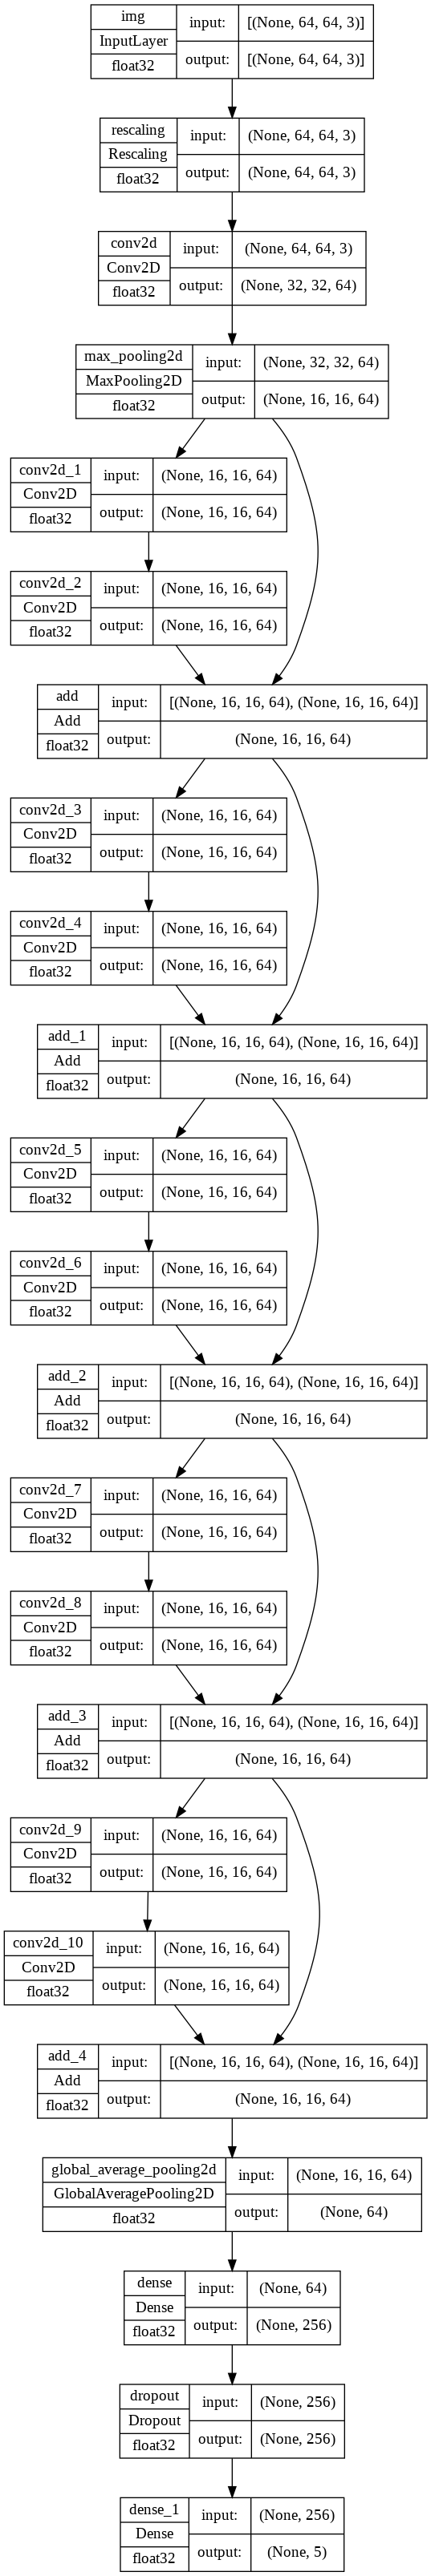

In [9]:
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

In [10]:
hist = model.fit(train_ds, epochs=25, validation_data=valid_ds, verbose=1)

Epoch 1/25
58/58 [==============================] - 10s 22ms/step - loss: 1.5963 - accuracy: 0.2326 - val_loss: 1.5697 - val_accuracy: 0.2593
Epoch 2/25
58/58 [==============================] - 1s 16ms/step - loss: 1.5766 - accuracy: 0.2647 - val_loss: 1.5504 - val_accuracy: 0.3241
Epoch 3/25
58/58 [==============================] - 1s 16ms/step - loss: 1.5489 - accuracy: 0.3217 - val_loss: 1.5069 - val_accuracy: 0.4012
Epoch 4/25
58/58 [==============================] - 1s 16ms/step - loss: 1.5003 - accuracy: 0.3516 - val_loss: 1.5323 - val_accuracy: 0.3272
Epoch 5/25
58/58 [==============================] - 1s 20ms/step - loss: 1.4334 - accuracy: 0.3880 - val_loss: 1.5919 - val_accuracy: 0.3025
Epoch 6/25
58/58 [==============================] - 2s 24ms/step - loss: 1.3769 - accuracy: 0.3973 - val_loss: 1.2413 - val_accuracy: 0.4846
Epoch 7/25
58/58 [==============================] - 1s 16ms/step - loss: 1.3478 - accuracy: 0.4250 - val_loss: 1.3010 - val_accuracy: 0.4815
Epoch 8/25
5

In [11]:
loss_test, pred_test = model.evaluate(test_ds)
print("Testing accuracy (%) =", pred_test*100)

8/8 [==============================] - 0s 8ms/step - loss: 1.2003 - accuracy: 0.5160
Testing accuracy (%) = 51.5999972820282


In [12]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

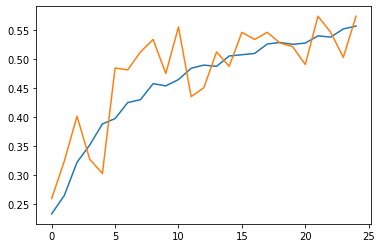

In [13]:
plt.figure()
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])